### Flow model loading

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
import sys
import matplotlib.pyplot as plt
from torchvision import utils
sys.path.append('../..')
flows = []
flow_names = []

#### From a trained FlowModel

In [2]:
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
TRAINED_FLOWMODELS = ['/home/macron/Praca Magisterska/Gotowe Sieci/flow_3ep_start_epclear_nolimit.pkl']

class AutopickleModel(Callback): #Thing that was helping with pickling is also messing up pickling, how delightful
    def __init__(self, model):
        self.model = model

    def on_validation_epoch_end(self, trainer, module):
        model_file = open(args.save_path, 'wb')
        # The base model should not need it anymore- and it's a bit messing up pickling
        self.model.base_model.train_dataloader = None
        self.model.base_model.val_dataloader = None
        self.model.base_model.trainer = None
        pkl.dump(self.model, model_file)
        model_file.close()

for path in TRAINED_FLOWMODELS:
    model_file = open(path, 'rb')
    model = pickle.load(model_file)
    model_file.close()
    model.cuda()
    flow_names.append(path.split('/')[-1].replace('.pkl', ''))
    flow = model.flow
    flows.append(flow)

backbone = nn.Sequential(model.base_model, model.embedding_model).cuda()

#### From a pickle

In [3]:
PICKLED_FLOWS = ['/home/macron/Praca Magisterska/Gotowe Sieci/conditional_all_backgrounds.pkl',
                 '/home/macron/Praca Magisterska/Gotowe Sieci/classic_all_backgrounds.pkl',
                 '/home/macron/Praca Magisterska/Gotowe Sieci/classic_100_backgrounds.pkl',
                 '/home/macron/Praca Magisterska/Gotowe Sieci/classic_10_backgrounds.pkl',
                 '/home/macron/Praca Magisterska/Gotowe Sieci/nice_all_backgrounds.pkl',]
for path in PICKLED_FLOWS:
    FLOW_PATH = 'trained_model.pkl'
    model_file = open(path, 'rb')
    flow = pickle.load(model_file)
    flow_names.append(path.split('/')[-1].replace('.pkl', ''))
    flows.append(flow)

### Pick images

In [4]:
import os
import os.path
import sys
from data.folder import IMG_EXTENSIONS, make_dataset

root_path = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/original/train'
foregrounds_path = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/only_fg/train'
backgrounds_path = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/only_bg_t/train'

def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, class_to_idx = find_classes(root_path)

foregrounds = make_dataset(foregrounds_path, class_to_idx, IMG_EXTENSIONS)
backgrounds = make_dataset(backgrounds_path, class_to_idx, IMG_EXTENSIONS)

In [5]:
from numpy.random import default_rng

SAMPLES = 1000

rng = default_rng(42)
selected_foregrounds = rng.choice(foregrounds, size=1)
selected_backgrounds = rng.choice(backgrounds, size=SAMPLES)

/home/macron/Praca Magisterska/Kod/RobOptWUST/data/only_fg/train/00_dog/n02109047_22481.JPEG


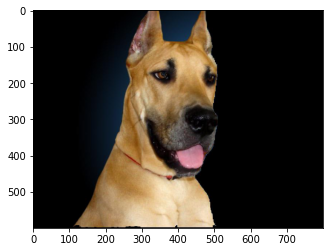

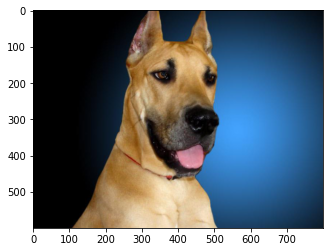

In [6]:
from data.shared import default_loader

print(selected_foregrounds[0][0])
def get_base_image(image_type=None):
    path = selected_foregrounds[0][0]
    if image_type is not None:
        path = selected_foregrounds[0][0].replace(foregrounds_path, image_type)
    return default_loader(path)

foreground = get_base_image(None)
base_image = get_base_image(root_path)
plt.imshow(foreground)
plt.show()
plt.imshow(base_image)

### Creating embeddings

In [7]:
import torch
import torchvision.transforms.functional as TF
from data.shared import set_background
from nflows.distributions.normal import ConditionalDiagonalNormal

def prepare_any_image(image):
    return TF.resize(TF.pil_to_tensor(image), (224, 224))/255.

def get_embedding(image):
    x = backbone(image[0].unsqueeze(0).cuda())
    return x[0].squeeze(0)

def prepare_image(foreground, background):
    image = set_background(foreground, TF.pil_to_tensor(background))
    return get_embedding(image)

def get_flowed(flows, images, context):
    xs = []
    for flow in flows:
        if isinstance(flow._distribution, ConditionalDiagonalNormal):
            xs.append(flow.transform_to_noise(images, context))
        else:
            xs.append(flow.transform_to_noise(images))
    return xs

embeddings, classes = torch.stack([prepare_image(foreground, default_loader(background[0])) for background in selected_backgrounds]), [background[1] for background in selected_backgrounds]

In [8]:
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, classes, highlighted=None, title='', ax=None):
    tsne = TSNE(n_components=2, random_state=42, perplexity=5, learning_rate='auto', n_iter=5000, init='pca')
    tsned = tsne.fit_transform(np.concatenate((embeddings, highlighted)))[:,:3]
    x, y = tsned.T

    if ax is None:
        fig, ax = plt.subplots(
            figsize=(6, 6),
            facecolor="white",
            tight_layout=True
        )
    ax.set_title(title, size=16)
    col = ax.scatter(x[:-1], y[:-1], c=[int(c) for c in classes], s=50, cmap='Pastel1', alpha=0.8)
    if highlighted is not None:
        hx, hy = [x[-1]], [y[-1]]
        col = ax.scatter(hx, hy, c=[1], s=100, cmap='viridis', alpha=1)

def visualize_mulitple_embeddings(mult_emb, classes, mult_highlighted, titles):
    fig, axs = plt.subplots(3, len(mult_emb)//3, figsize=(6 * (len(mult_emb) // 3), 6 * 3))
    axs = axs.flatten()
    for (emb, highlighted, title, ax) in zip(mult_emb, mult_highlighted, titles, axs):
        visualize_embeddings(emb.cpu().detach().numpy(), classes, highlighted=np.array([highlighted.cpu().detach().numpy()]), title=title, ax=ax)

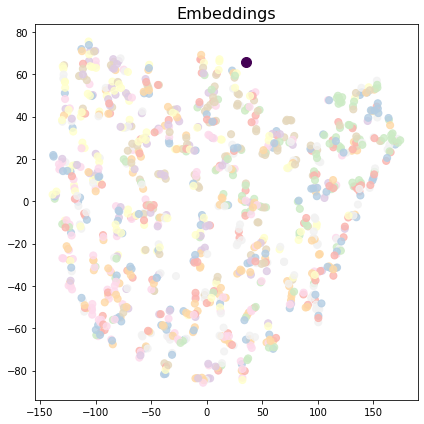

In [9]:
import numpy as np
base = get_embedding([prepare_any_image(base_image)])
visualize_embeddings(embeddings.cpu().detach().numpy(), classes, highlighted=np.array([base.cpu().detach().numpy()]), title='Embeddings')

In [10]:
embeddings_flowed = get_flowed(flows, embeddings, base.repeat(1000, 1))
base_flowed = get_flowed(flows, base.unsqueeze(0), base.unsqueeze(0))

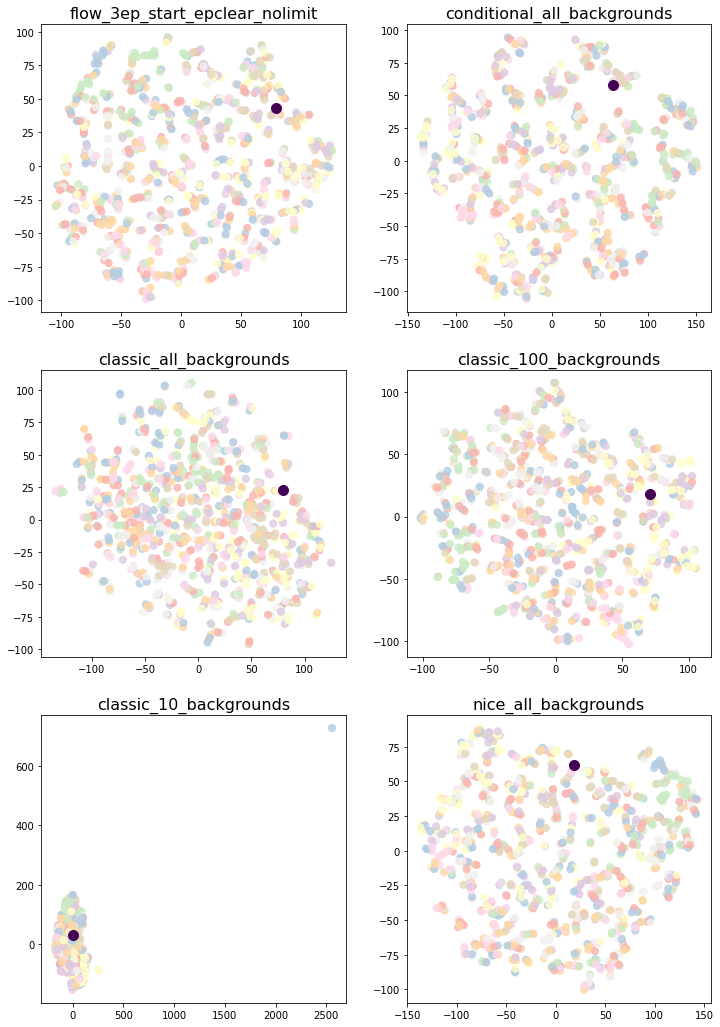

In [11]:
visualize_mulitple_embeddings(embeddings_flowed, classes, [bf.squeeze(0) for bf in base_flowed], titles=flow_names)

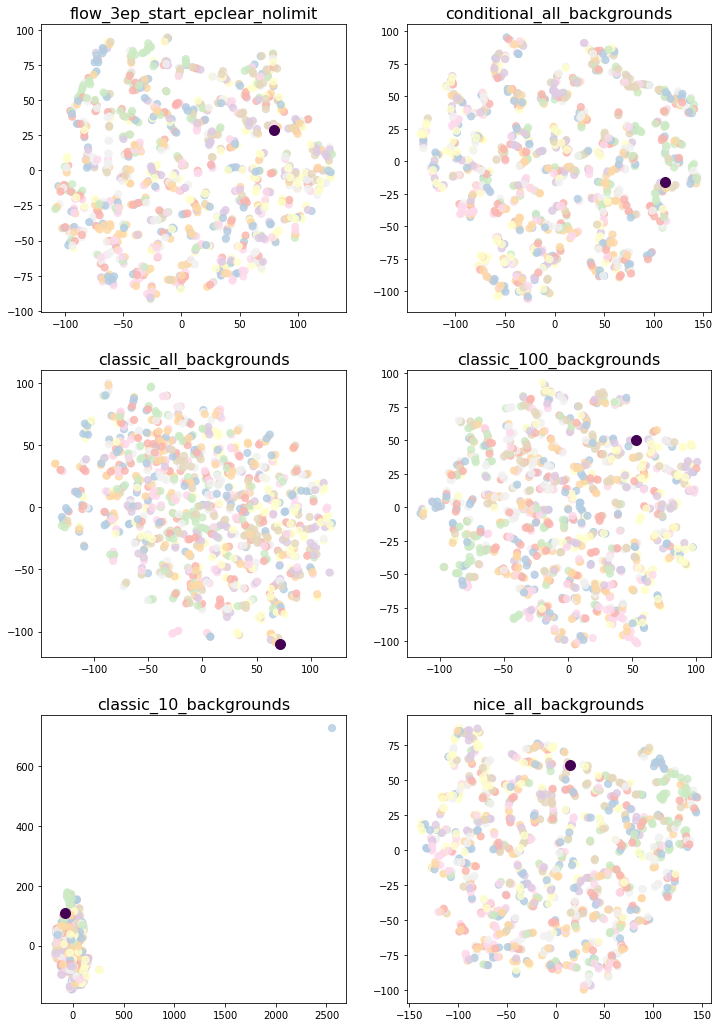

In [12]:
no_background_image = get_base_image()
no_background_embedding = get_embedding([prepare_any_image(no_background_image)])
no_background_flowed = get_flowed(flows, no_background_embedding.unsqueeze(0), no_background_embedding.unsqueeze(0))

visualize_mulitple_embeddings(embeddings_flowed, classes, [bf.squeeze(0) for bf in no_background_flowed], titles=flow_names)